<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
#!pip install xgboost

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_regression, chi2, RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import xgboost as xgb

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv', dtype={'MSSubClass':'str', 'OverallQual':'str', 'OverallCond':'str'})
house.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)
# Drop 'Id' column as it is not useful for analysis
house = house.drop('Id', axis = 1)
# Dropping non-residential houses
house = house.drop(house[house['MSZoning'] == 'C (all)'].index)
# Getting the indices of the houses sold in 2010 and prior to 2010
index_2010 = house.loc[house['YrSold'] == 2010].index
index_pre_2010 = house.loc[house['YrSold'] != 2010].index

house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null object
OverallCond      1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 n

In [3]:
# The following describe() is to check for any strange value in numerical columns
# house.iloc[:,:40].describe()
# house.iloc[:,40:60].describe()
# house.iloc[:,60:].describe()

# 1st Approach: Statistical tests & Modelling

# Feature Engineering
## Getting the Age of the Houses
Define: Age of the houses = the year the house is sold - the year the house is remodelled <br>
If there is no remodeling, remodal year will be the year built. 

In [4]:
# Checking the proportion of houses that have been remodelled. 
sum(house['YearBuilt'] == house['YearRemodAdd'])/len(house['YearBuilt'])

0.5262068965517241

Conclusion: ~52% of the houses have been remodelled. Can be an attribute to explore in the future. For now we will take the remodelling year, which consists of the year built if there  is no remodel.

Furthermore, we will drop the 'year' and 'month' features since the info has been captured by the 'Age'. In addition, we will drop the 'year' the garage is built since the focus is more on the garage itself. 

In [5]:
house.loc[:,'Age'] = house['YrSold'] - house['YearRemodAdd']
house.shape

(1450, 81)

# Identifying Fixed and 'Renovate-able' features
<p>The assumption is numerical features are mainly square feet of different areas in a house. As such, unless there are major overhaul and construction done to a house, which we are not doing so, the numerical features are going to remain fixed. This implies that renovate-able features are found in categorical features only. E.g. The material used for the roof. Noted that SaleCondition and SaleType are not physical parts of a house. Hence we also have to remove them from renovate-able features. </p>
Number of fixed categorical features: 21 <br>
Number of renovate-able categorical features: 23 <br>
Number of fixed numerical features: 29

In [6]:
categorical_all = list(house.select_dtypes('object').columns)

numerical_features_fixed = ['LotFrontage', 'LotArea', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'SndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'Age']
categorical_features_fixed = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
       'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'Functional',
       'GarageType', 'PoolQC', 'MiscFeature']
categorical_features_reno = list(set(categorical_all) - set(categorical_features_fixed))
# Remove features that are neither fixed nor renovate-able.
categorical_features_reno.remove('SaleType')
categorical_features_reno.remove('SaleCondition')

print('Fixed categorical features size: ', len(categorical_features_fixed))
print('Revo categorical features size: ', len(categorical_features_reno))
print('Fixed numeric features size: ', len(numerical_features_fixed))

Fixed categorical features size:  21
Revo categorical features size:  23
Fixed numeric features size:  29


# Exploratory Data Analysis

## Working on Fixed Numeric Features

### 1. Impute NaN values
Impute with reasonable values based on their categorical counterparts. Else, impute with the features' mean values. 

In [7]:
house[numerical_features_fixed].info()

house.loc[house['LotFrontage'].isnull(),'LotFrontage'] = house['LotFrontage'].mean()

#print(house[house['MasVnrArea'].isnull()][['MasVnrArea', 'MasVnrType']])
#The Masonry veneer area in square feet cannot be determined by its type. Hence, we shall replace the nan
# with the mean of the column.
house.loc[house['MasVnrArea'].isnull(),'MasVnrArea'] = house['MasVnrArea'].mean()

print('After imputation:')
house[numerical_features_fixed].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 29 columns):
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
MasVnrArea       1442 non-null float64
BsmtFinSF1       1450 non-null int64
BsmtFinSF2       1450 non-null int64
BsmtUnfSF        1450 non-null int64
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
SndFlrSF         1450 non-null int64
LowQualFinSF     1450 non-null int64
GrLivArea        1450 non-null int64
BsmtFullBath     1450 non-null int64
BsmtHalfBath     1450 non-null int64
FullBath         1450 non-null int64
HalfBath         1450 non-null int64
BedroomAbvGr     1450 non-null int64
KitchenAbvGr     1450 non-null int64
TotRmsAbvGrd     1450 non-null int64
Fireplaces       1450 non-null int64
GarageCars       1450 non-null int64
GarageArea       1450 non-null int64
WoodDeckSF       1450 non-null int64
OpenPorchSF      1450 non-null int64
EnclosedPorch    1450 non-null int64
3

### 2. Fixing Multicollinearity
Using variance inflation factor (VIF), we look out for multicollinear features and fix them before modelling. This is to reduce the unusual behaviour due to multicollinearity. We write a function to remove the features recursively, till all features' VIF is less than the threshold (10). If there is a tie, we will drop the feature that has the lowest variance, as it has the least 'information' contained within. 

In [8]:
def remove_large_vif(data, features, threshold):
    '''
    Remove features with VIF larger than threshold recursively, till all features have VIF lesser than the threshold.
    Criterion used for removal in the event of ties: feature with lowest variance.
    '''
    variance = np.var(data[features])
    working = []
    for idx, val in enumerate(features):
        vif_value = vif(data[features].values, idx)
        working.append((val, vif_value, variance[idx]))
    working.sort(key=lambda x: x[2])
    working.sort(key=lambda x: x[1], reverse=True)
    while (working[0][1] > threshold):
        print('Removing feature "'+ working[0][0] +'"')
        print('VIF:', working[0][1])
        print('Variance', working[0][2])
        features.remove(working[0][0])
        variance = np.var(data[features])
        working = []
        for idx, val in enumerate(features):
            vif_value = vif(data[features].values, idx)
            working.append((val, vif_value, variance[idx]))
        working.sort(key=lambda x: x[2])
        working.sort(key=lambda x: x[1], reverse=True)

remove_large_vif(house, numerical_features_fixed, 10)
print('Done removing high VIF features.')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removing feature "LowQualFinSF"
VIF: inf
Variance 2201.1842092745774
Removing feature "BsmtFinSF2"
VIF: inf
Variance 26170.388706778605
Removing feature "GrLivArea"
VIF: 1251.434444973293
Variance 275596.74296361423
Removing feature "TotRmsAbvGrd"
VIF: 78.8094576830683
Variance 2.6398577883472147
Removing feature "TotalBsmtSF"
VIF: 77.30056691965659
Variance 192770.0348161713
Removing feature "1stFlrSF"
VIF: 40.46572291104821
Variance 149392.10231105826
Removing feature "GarageCars"
VIF: 34.48567236556437
Variance 0.5548447086801349
Removing feature "BedroomAbvGr"
VIF: 21.238094637585466
Variance 0.6631895362663555
Removing feature "KitchenAbvGr"
VIF: 17.598629190363734
Variance 0.048209750297264424
Removing feature "FullBath"
VIF: 12.916289060410769
Variance 0.30179548156955793
Removing feature "LotFrontage"
VIF: 11.188900664623167
Variance 484.64942586641195
Done removing high VIF features.


### 3. Correlation between features and with the target 'SalePrice'
A naive way to see how numeric features correlate with each others and the target.

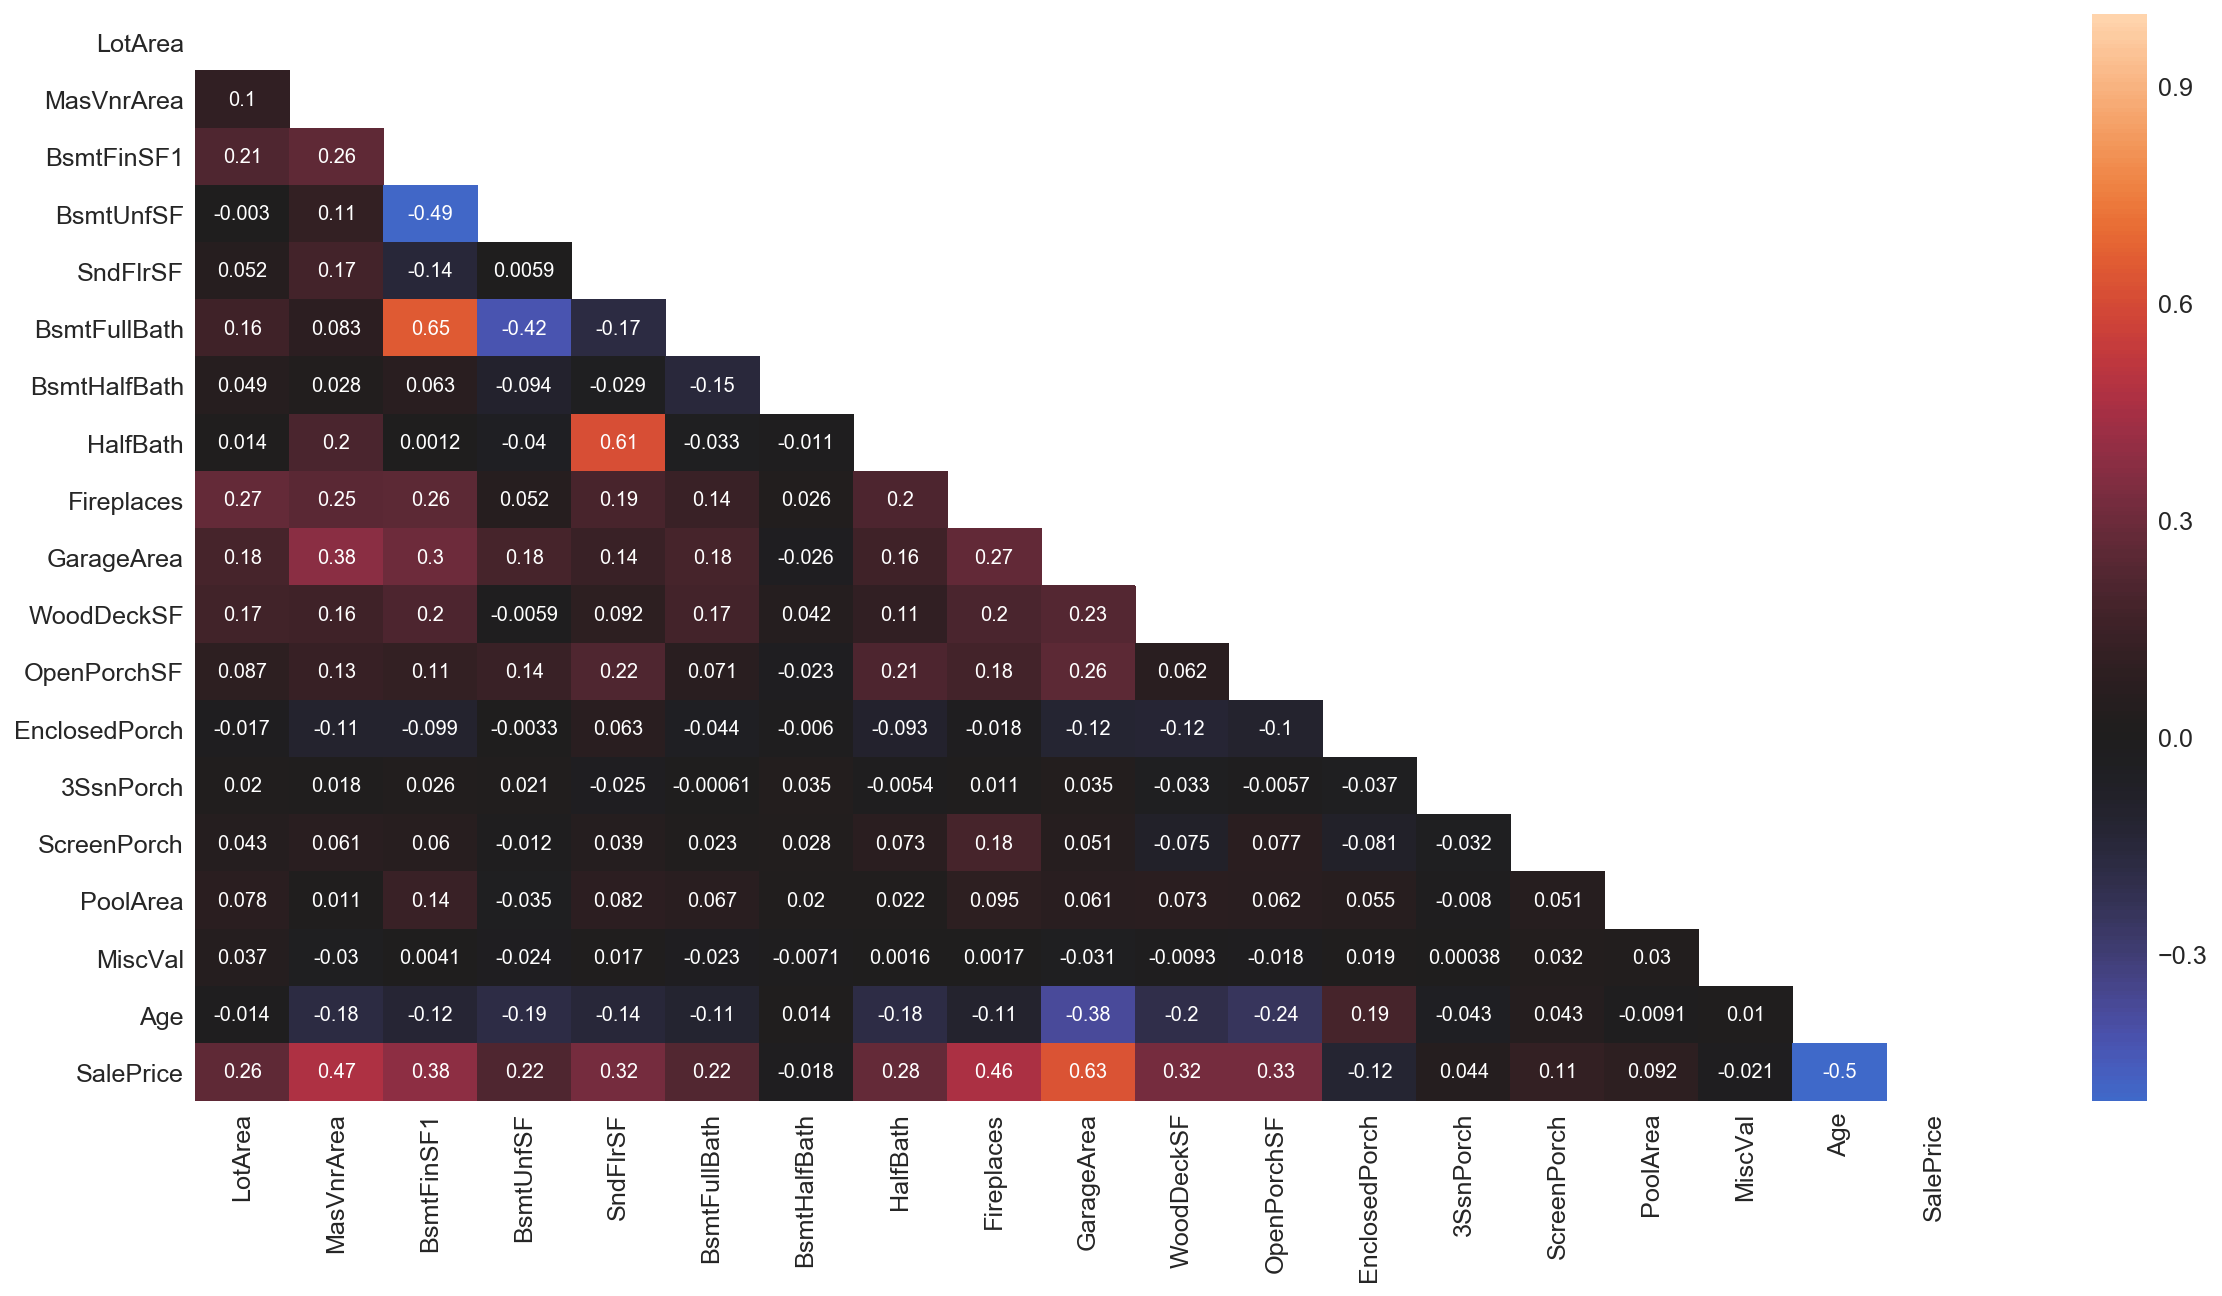

In [9]:
corr = house[numerical_features_fixed+['SalePrice']].corr()
plt.figure(figsize=(20,10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, mask=mask);

We remove those features with high correlation with another feature, and yet have low variances.

In [10]:
print('Variance of BsmtFullBath and BsmtFinSF1: ', np.var(house['BsmtFullBath']), np.var(house['BsmtFinSF1']))
print('Variance of HalfBath and SndFlrSF: ', np.var(house['HalfBath']), np.var(house['SndFlrSF']))
numerical_features_fixed.remove('BsmtFullBath')
numerical_features_fixed.remove('HalfBath')

Variance of BsmtFullBath and BsmtFinSF1:  0.2695838287752666 208115.22868204623
Variance of HalfBath and SndFlrSF:  0.2532870392390056 190919.63334886832


In [11]:
def ttest_scores(data, features, target):
    for feature in features:
        print(feature)
        print('Number of non-zero values for this feature:', len(data[data[feature] != 0]))
        print(stats.ttest_ind(data[data[feature] != 0][target], data[data[feature] == 0][target], equal_var=False))

### 4. Further Tests for low correlation between features and target 'SalePrice'

### Does having a pool affect the sale price?
There are only 7 out of 1,450 houses with swimming pools (PoolArea), and they are the ones with pool quality (PoolQC). Hence, by separating into 2 samples, where 1 sample has houses with pools ($PoolArea \neq 0$) and the other has houses without pools ($PoolArea = 0$), we use Welch's unequal variances t-test to answer this hypothesis: 

H0: The SalePrice means of both samples are equal. <br>
H1: The SalePrice means of both samples are unequal. 

In [12]:
# stats.ttest_ind(house[house['PoolArea'] != 0]['SalePrice'], house[house['PoolArea'] == 0]['SalePrice'], equal_var=False)
ttest_scores(house, ['PoolArea'], 'SalePrice')

PoolArea
Number of non-zero values for this feature: 7
Ttest_indResult(statistic=1.3732968146367783, pvalue=0.2187025928536115)


Conclusion: The means of both samples are likely to be equal. This implies that we can drop both PoolArea and PoolQC features as they don't provide more information to our target SalePrice in this dataset. 

In [13]:
numerical_features_fixed.remove('PoolArea')
categorical_features_fixed.remove('PoolQC')

### Does having a miscellaneous feature affect the sale price?
There are 52 out of 1,450 houses with miscellaneous features (MiscFeature). By splitting into a sample of houses with miscellaneous features and a sample of houses without, we use Welch's unequal variances t-test to answer this hypothesis:

H0: The SalePrice means of both samples are equal. <br>
H1: The SalePrice means of both samples are unequal.

In [14]:
stats.ttest_ind(house[~house['MiscFeature'].isnull()]['SalePrice'], house[house['MiscFeature'].isnull()]['SalePrice'], equal_var=False)

Ttest_indResult(statistic=-3.7472967349500146, pvalue=0.0004009757932846378)

Conclusion: There is statistically significant difference between the SalePrice means of both samples. This implies that we need to consider having both the MiscFeature and MiscVal features, as they give some information to the target SalePrice. 

### How about other features that have low correlation with 'SalePrice'?

In [15]:
ttest_scores(house, ['BsmtHalfBath','EnclosedPorch', '3SsnPorch', 'ScreenPorch'], ['SalePrice'])

BsmtHalfBath
Number of non-zero values for this feature: 81
Ttest_indResult(statistic=array([-0.6094183]), pvalue=array([0.5438014]))
EnclosedPorch
Number of non-zero values for this feature: 202
Ttest_indResult(statistic=array([-8.2428275]), pvalue=array([4.11162537e-15]))
3SsnPorch
Number of non-zero values for this feature: 24
Ttest_indResult(statistic=array([1.88458665]), pvalue=array([0.07168072]))
ScreenPorch
Number of non-zero values for this feature: 115
Ttest_indResult(statistic=array([2.98708906]), pvalue=array([0.00336855]))


Conclusion: We remove features that have p-value > 0.05, as the 'SalePrice' means between 2 samples are not statistically significant. 

In [16]:
numerical_features_fixed.remove('BsmtHalfBath')
numerical_features_fixed.remove('3SsnPorch')

In [17]:
print('Numerical fixed features final candidates:', numerical_features_fixed)

Numerical fixed features final candidates: ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'SndFlrSF', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'Age']


## Working on Fixed Categorical Features

In [18]:
house[categorical_features_fixed] = house[categorical_features_fixed].fillna('missing')
house[categorical_features_fixed] = house[categorical_features_fixed].astype(str)

### 1. Between Fixed Categorical Features and SalePrice Target
First, using statsmodels and ANOVA one-way test between fixed categorical features and continuous SalePrice target, we can exclude features that exhibit low association/relationship with the target.

If the p value is more than 5%, we do not reject the idea that each levels of a categorical feature has level mean close to another level mean. This implies that as a whole, this specific feature has exhibited low association/relationship with the target where segregation within the feature doesn't provide much more information to the target prediction. 

In [19]:
categorical_list_drop = []
for feature in categorical_features_fixed:
    formula = f'SalePrice ~ C({feature})'
    result = smf.ols(formula, data=house).fit()
    if result.f_pvalue > 0.05:
        print(feature, result.f_pvalue)
        categorical_list_drop.append(feature)
        categorical_features_fixed.remove(feature)
print('Dropped following categorical features:', categorical_list_drop)
print('Fixed categorical features size: ', len(categorical_features_fixed))

Street 0.6021777169381333
Utilities 0.5771100383545511
LandSlope 0.06628620730152941
Condition2 0.06294307662463175
MiscFeature 0.06338436491536728
Dropped following categorical features: ['Street', 'Utilities', 'LandSlope', 'Condition2', 'MiscFeature']
Fixed categorical features size:  15


### 2. Between 2 Categorical Features
Next, for all fixed categorical features, we find the association between 2 features. The idea is similar to finding correlations between 2 numerical features, where we don't need to have both features if both exhibit strong correlation in either directions. By conducting chi-squared test and Shannon's entropy, we are able to reduce the number of categorical features selected. 

For Shannon's entropy, the higher the value is, the more information we can get from the feature. It's analogous to the variance of the numerical features. 

For chi-squared test, the p-value gives us the probability that what we observed is by chance. A low p-value (less than 0.05) suggests that there are associations between the 2 categorical variables, as the probability of what we have observed due to chance is low. Another way of saying is that they are likely to be dependent. 

In [20]:
entropy = [(feature,stats.entropy(house[feature].value_counts())) for feature in categorical_features_fixed]
# Sort from the highest entropy to the lowest entropy
entropy.sort(key=lambda x: x[1], reverse=True)
entropy

[('Neighborhood', 2.9019340676156333),
 ('MSSubClass', 2.0219929908384575),
 ('HouseStyle', 1.284897544860129),
 ('BsmtQual', 1.1153322050744345),
 ('GarageType', 1.0921461065404852),
 ('BsmtExposure', 1.077048745121444),
 ('Foundation', 1.052180237473659),
 ('LotConfig', 0.8499655465708177),
 ('LotShape', 0.791480670297025),
 ('MSZoning', 0.6571055442243019),
 ('BldgType', 0.654289777241731),
 ('Condition1', 0.6213935399683578),
 ('LandContour', 0.43208201362166715),
 ('Functional', 0.3534047438262423),
 ('Alley', 0.27282088156695883)]

In [21]:
def chi2_scores(data, features):
    scores_list = []
    use = True
    for idx, feature1 in enumerate(features):
        for feature2 in features[idx+1:]:
            more_than_5 = 0
            ct = pd.crosstab(data[feature1], data[feature2])
            _, p_value, _, expected = stats.chi2_contingency(ct)
            for row in expected:
                for cell in row:
                    if cell < 0:
                        use = False
                    if cell >= 5:
                        more_than_5 += 1
            if (more_than_5/len(expected.ravel()) >= 0.8):
                print(more_than_5/len(expected.ravel()))
                print(use)
                print(expected)
            if (more_than_5/len(expected.ravel()) < 0.8):
                use = False
            if (p_value < 0.05 and use):
                scores_list.append((feature1, feature2, p_value))
    scores_list.sort(key=lambda x: x[2])
    return scores_list
chi2_scores(house, categorical_features_fixed)

[]

Conclusion: Since each expected matrix does not have values more than 5 for more than 80%, chi-squared test may not be useful here.

## Working between Fixed Categorical and Numerical Features

### 1. One-way ANOVA between fixed categorical and numerical features
Using one-way ANOVA test, we check the p-value between the features. If it's less than 0.05, we count the categorical features accordingly. Features that appear frequently will be removed. 

In [22]:
counts = {feature_cat:0 for feature_cat in categorical_features_fixed}
for feature_num in numerical_features_fixed:
    for feature_cat in categorical_features_fixed:
        formula = feature_num + ' ~ C(' + feature_cat + ')'
        result = smf.ols(formula, data=house).fit()
        #    print(result.summary())
        if result.f_pvalue < 0.05:
            print(feature_num, feature_cat, result.f_pvalue)
            counts[feature_cat] += 1
counts

LotArea MSSubClass 6.350804451252439e-16
LotArea MSZoning 1.6776389394951197e-13
LotArea Alley 0.005482269463964492
LotArea LotShape 2.2676252540099733e-46
LotArea LandContour 2.3962589394946714e-49
LotArea LotConfig 4.9840743274839174e-11
LotArea Neighborhood 4.4531888760200007e-45
LotArea BldgType 2.1920733636618345e-17
LotArea BsmtQual 0.03918856310354151
LotArea BsmtExposure 3.793858053595074e-25
LotArea GarageType 9.22457121033333e-07
MasVnrArea MSSubClass 6.058658955745422e-24
MasVnrArea MSZoning 9.542150873881901e-05
MasVnrArea Alley 0.001348575415933611
MasVnrArea LotShape 0.001152996777041577
MasVnrArea Neighborhood 1.910609180882286e-81
MasVnrArea Condition1 0.03462937026193168
MasVnrArea BldgType 0.016218292080949655
MasVnrArea HouseStyle 2.3171201165457587e-12
MasVnrArea Foundation 5.012671369839717e-16
MasVnrArea BsmtQual 1.4738255809037032e-42
MasVnrArea BsmtExposure 6.581764907198233e-11
MasVnrArea Functional 0.044278739108558916
MasVnrArea GarageType 2.9939517408860404e

{'MSSubClass': 11,
 'MSZoning': 10,
 'Alley': 10,
 'LotShape': 11,
 'LandContour': 8,
 'LotConfig': 7,
 'Neighborhood': 12,
 'Condition1': 8,
 'BldgType': 10,
 'HouseStyle': 10,
 'Foundation': 11,
 'BsmtQual': 11,
 'BsmtExposure': 13,
 'Functional': 3,
 'GarageType': 11}

The result shows that 11 features appear 10 times or more when we test ANOVA against other numerical features. This implies that the information from these 11 features has statistically significant association with other numerical features, which means that their information can mostly found 'embedded' in other numerical features. 

In [23]:
for key, val in counts.items():
    if val >= 10:
        categorical_features_fixed.remove(key)
print('Categorical fixed features final candidates:', categorical_features_fixed)

Categorical fixed features final candidates: ['LandContour', 'LotConfig', 'Condition1', 'Functional']


In [24]:
print('Fixed features final candidates:', categorical_features_fixed + numerical_features_fixed)

Fixed features final candidates: ['LandContour', 'LotConfig', 'Condition1', 'Functional', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'SndFlrSF', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'Age']


# Model Training

### 1. Split the data
Split the train-test set into houses that are sold before 2010 (train) and in 2010 (test).

In [25]:
X_train = house.loc[index_pre_2010, numerical_features_fixed + categorical_features_fixed]
y_train = house.loc[index_pre_2010, ['SalePrice']]

X_test = house.loc[index_2010, numerical_features_fixed + categorical_features_fixed]
y_test = house.loc[index_2010, ['SalePrice']]

print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of testing set:", X_test.shape, y_test.shape)

Shape of training set: (1278, 17) (1278, 1)
Shape of testing set: (172, 17) (172, 1)


### 2. Build the pipeline
Preprocessing pipeline consists of ColumnTransformer, which transforms the columns according to the type (numerical or categorical) of the features. 

In [26]:
# Preprocessing pipeline for numeric features
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(verbose = 1)),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing', verbose = 1)),
    ('onehot', OneHotEncoder(categories = 'auto', handle_unknown = 'ignore'))
])

# Transform each column of the selected features according to types (numeric/categorical)
preprocessor = ColumnTransformer(
    [
        ('numeric', numerical_transformer, numerical_features_fixed),
        ('categorical', categorical_transformer, categorical_features_fixed)
    ], 
    n_jobs=-1
)

### 2a. Ridge Regression
Desired alpha: 53.429090049316144 <br>
Score on train set: 0.7090444396081483 <br>
Score on test set: 0.7506410887305933

In [27]:
classifier_ridge = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('ridge', Ridge(max_iter = 10000))
])

params = {
    'ridge__alpha': np.logspace(1.7, 1.75, 10)
}

ridge_gridsearcher = GridSearchCV(classifier_ridge, params, cv = 10, verbose = 1, n_jobs=-1, iid=False, return_train_score=True)
ridge_gridsearcher.fit(X_train, y_train)

print(ridge_gridsearcher.best_score_)
print(ridge_gridsearcher.best_params_)
print('Score on test set:')
ridge_gridsearcher.score(X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s


0.7090444396081483
{'ridge__alpha': 53.429090049316144}
Score on test set:


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished


0.7506410887305933

### 2b. ElasticNet Regression
Desired alpha: 0.10259143654700097 <br>
Desired l1_ratio: 0.55 <br>
Score on train set: 0.7090458882024543 <br>
Score on test set: 0.749795742807577

In [28]:
classifier_eNet = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet(max_iter = 10000))
])

params = {
    'elasticnet__alpha': np.logspace(-1, -0.95, 10),
    'elasticnet__l1_ratio': np.linspace(0.5, 0.6, 5)
}

eNet_gridsearcher = GridSearchCV(classifier_eNet, params, cv = 10, verbose = 1, n_jobs=-1, iid=False, return_train_score=True)
eNet_gridsearcher.fit(X_train, y_train)

print(eNet_gridsearcher.best_score_)
print(eNet_gridsearcher.best_params_)
print('Score on test set:')
eNet_gridsearcher.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.9s


0.7090458882024543
{'elasticnet__alpha': 0.10259143654700097, 'elasticnet__l1_ratio': 0.55}
Score on test set:


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   44.9s finished


0.749795742807577

In [29]:
eNet_gridsearcher.best_estimator_.named_steps['elasticnet'].coef_

array([  4518.9824961 ,   9489.00815814,  23579.24322968,  18967.23718922,
        17380.65762935,  12651.76581693,  18377.57149935,   6191.82882547,
         3696.73746023,    371.58276597,   3630.44554411,   -942.02484947,
       -16854.0834837 ,  -6516.3593322 ,   8319.79457558,  -1047.12839877,
         -753.86254468,  -3566.86568799,   7559.11712852,  -2646.70819069,
           47.03370693,  -1391.32439294,  -2639.02304938,  -5416.19717036,
         8899.68569623,   1066.18310361,  -2341.58770206,  -1854.02774121,
         1147.04873351,     27.63643191,   1109.05983509,   -450.50770773,
        -1881.73797565,   -543.85203755,  -3054.9438561 ,  -1479.02896534,
         -992.02202605,   8408.2035182 ])

# 2nd approach: Using XGBoost

XGBoost has proven its worth through the ubiquitous usage in Kaggle, and winning the top position in competitions. Decided to push the boundary of Question 1 by deploying XGBoost here and hopefully it yields better result.

In [30]:
# Load the data
house = pd.read_csv('./housing.csv', dtype={'MSSubClass':'str', 'OverallQual':'str', 'OverallCond':'str'})
# Drop 'Id' column as it is not useful for analysis
house = house.drop('Id', axis=1)
# Dropping non-residential houses
house = house.drop(house[house['MSZoning'] == 'C (all)'].index)
# Create 'Age' feature
house.loc[:,'Age'] = house['YrSold'] - house['YearRemodAdd'];
# Extract the index of the houses which are 2010s and pre-2010s. 
index_2010 = house.loc[house['YrSold'] == 2010].index
index_pre_2010 = house.loc[house['YrSold'] != 2010].index
# Drop columns that are not needed for modelling
# house = house.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 'GarageYrBlt'], axis=1)
print(house.shape)
house.info()

(1450, 81)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null object
OverallCond      1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd 

In [31]:
numerical_features_fixed = ['LotFrontage', 'LotArea', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'Age']
categorical_features_fixed = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
       'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', 'Functional',
       'GarageType', 'PoolQC', 'MiscFeature']

In [32]:
X = pd.get_dummies(house[numerical_features_fixed + categorical_features_fixed], dummy_na=True, drop_first=True)
X.fillna(X.mean(), inplace=True)
X[numerical_features_fixed] = (X[numerical_features_fixed] - X[numerical_features_fixed].mean()) / X[numerical_features_fixed].std()
X.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,...,GarageType_CarPort,GarageType_Detchd,GarageType_nan,PoolQC_Fa,PoolQC_Gd,PoolQC_nan,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_nan
0,-0.229444,-0.207131,0.506096,0.571568,-0.943041,-0.463127,-0.798594,1.159030,0.366181,1.102081,...,0,0,0,0,0,1,0,0,0,1
1,0.451682,-0.092271,-0.576868,1.167597,-0.640274,0.461265,0.251462,-0.794782,-0.486902,-0.823241,...,0,0,0,0,0,1,0,0,0,1
2,-0.093219,0.072528,0.318235,0.089486,-0.301357,-0.317410,-0.633068,1.186484,0.510900,1.102081,...,0,0,0,0,0,1,0,0,0,1
3,-0.456486,-0.097265,-0.576868,-0.502160,-0.061854,-0.690810,-0.527027,0.934822,0.379510,1.102081,...,0,1,0,0,0,1,0,0,0,1
4,0.633316,0.373162,1.356996,0.459813,-0.174827,0.194876,-0.051140,1.614310,1.295432,1.102081,...,0,0,0,0,0,1,0,0,0,1


In [33]:
X_train = X.loc[index_pre_2010, :]
y_train = house.loc[index_pre_2010, ['SalePrice']]

X_test = X.loc[index_2010, :]
y_test = house.loc[index_2010, ['SalePrice']]

print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of testing set:", X_test.shape, y_test.shape)

Shape of training set: (1278, 157) (1278, 1)
Shape of testing set: (172, 157) (172, 1)


In [34]:
# xgbrg = xgb.XGBRegressor(silent=False)

# param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }

# searchCV = GridSearchCV(xgbrg, cv=10, param_grid=param_grid, verbose=5, n_jobs=-1, return_train_score=True)
# searchCV.fit(X_train, y_train)

In [35]:
# joblib.dump(searchCV, 'xgboost_fixed_model.sav')

In [36]:
searchCV = joblib.load('xgboost_fixed_model.sav')

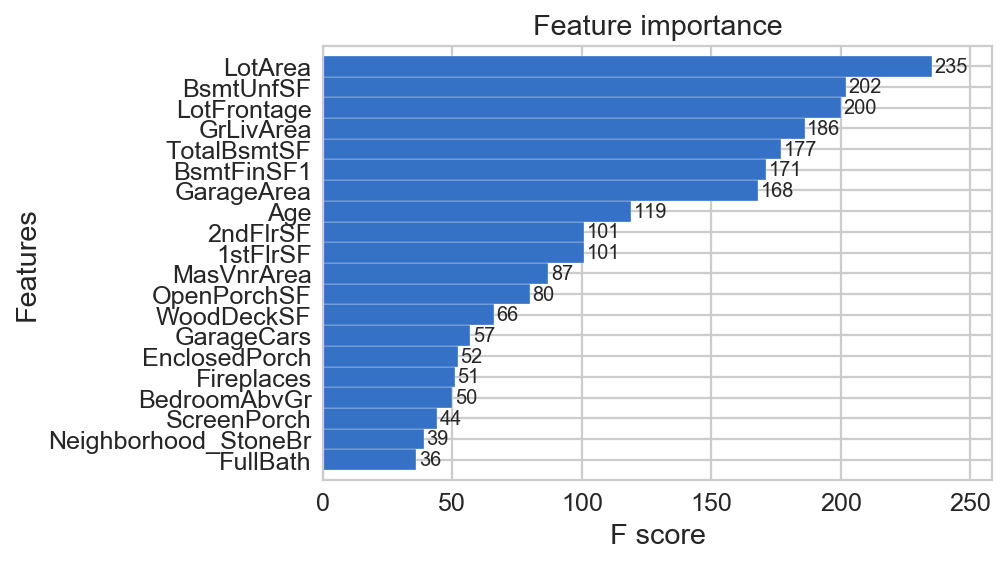

In [37]:
xgb.plot_importance(searchCV.best_estimator_, max_num_features=20, height = 1);

In [38]:
searchCV.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [39]:
searchCV.best_score_

0.8665702569130624

In [40]:
searchCV.score(X_test, y_test)

0.8516690137002775

In [41]:
top_features = sorted(searchCV.best_estimator_.get_booster().get_fscore().items(), key=lambda x: x[1], reverse=True)[:46]

In [42]:
xgb_features = [i[0] for i in top_features]
RFE = RFECV(Ridge(), cv = 10, verbose=10, n_jobs=-1)
RFE.fit(X.loc[index_pre_2010, xgb_features], house.loc[index_pre_2010, ['SalePrice']].values.ravel())

Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.


RFECV(cv=10,
   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
   min_features_to_select=1, n_jobs=-1, scoring=None, step=1, verbose=10)

In [43]:
final_fixed_features = [i[0] for i in zip(xgb_features, RFE.get_support()) if i[1] == True]
final_fixed_features = list(set([i.split('_')[0] for i in final_fixed_features]))
print('Final fixed features from XGBoost:', final_fixed_features)

Final fixed features from XGBoost: ['TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', '3SsnPorch', 'BsmtFullBath', 'OpenPorchSF', '1stFlrSF', 'LotShape', 'BedroomAbvGr', 'MSSubClass', 'Neighborhood', 'BsmtExposure', 'LotFrontage', 'LotConfig', 'GarageArea', 'Functional', 'EnclosedPorch', 'BsmtUnfSF', 'Age', 'TotRmsAbvGrd', 'BsmtFinSF1', 'LandContour', 'GarageType', 'GrLivArea', 'Condition1', 'LotArea', 'ScreenPorch', 'FullBath', 'BsmtQual', 'Fireplaces']


In [44]:
print(RFE.score(X.loc[index_pre_2010, xgb_features], y_train))
print(RFE.score(X.loc[index_2010, xgb_features], y_test))

0.8211118347150941
0.8489022916700979


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [45]:
reno_features = ['GarageCond',
 'BsmtCond',
 'FireplaceQu',
 'Exterior1st',
 'Electrical',
 'GarageFinish',
 'OverallQual',
 'RoofStyle',
 'BsmtFinType1',
 'Fence',
 'ExterQual',
 'HeatingQC',
 'KitchenQual',
 'ExterCond',
 'Heating',
 'CentralAir',
 'GarageQual',
 'OverallCond',
 'RoofMatl',
 'PavedDrive',
 'Exterior2nd',
 'BsmtFinType2',
 'MasVnrType']
reno_df = pd.get_dummies(house[reno_features], dummy_na = True)
skb = SelectKBest(f_regression)
skb.fit(reno_df.loc[index_pre_2010], house.loc[index_pre_2010, 'SalePrice'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SelectKBest(k=10, score_func=<function f_regression at 0x000001EEC4617E18>)

In [46]:
chosen_reno_features = list(reno_df.loc[:,skb.get_support()].columns)
chosen_reno_features = list(set([i.split('_')[0] for i in chosen_reno_features]))

Combining both fixed and renovate-able features

In [47]:
X = house[final_fixed_features + chosen_reno_features]
numerical_features_col = X.select_dtypes('number').columns
X.loc[:, numerical_features_col] = X.loc[:,numerical_features_col].fillna(X[numerical_features_col].mean())
X[numerical_features_col] = (X[numerical_features_col] - X[numerical_features_col].mean()) / X[numerical_features_col].std()
X = pd.get_dummies(X, dummy_na=True, drop_first=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [48]:
X_train = X.loc[index_pre_2010, :]
y_train = house.loc[index_pre_2010, ['SalePrice']]

X_test = X.loc[index_2010, :]
y_test = house.loc[index_2010, ['SalePrice']]

print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of testing set:", X_test.shape, y_test.shape)

Shape of training set: (1278, 142) (1278, 1)
Shape of testing set: (172, 142) (172, 1)


In [49]:
ridge = RidgeCV()
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.8893162510998164

In [50]:
dict(zip(X_train.columns,ridge.coef_[0]))

{'TotalBsmtSF': 631.8498897320824,
 'GarageCars': 8791.033931721468,
 '2ndFlrSF': 12168.436730544316,
 'MasVnrArea': 112.78354982478777,
 'WoodDeckSF': 2229.68020604545,
 '3SsnPorch': 1971.6250520905014,
 'BsmtFullBath': 2445.808448304073,
 'OpenPorchSF': 498.8240588341141,
 '1stFlrSF': 6467.571044560289,
 'BedroomAbvGr': -963.0352022000588,
 'LotFrontage': -3377.66905531846,
 'GarageArea': -662.5279388534254,
 'EnclosedPorch': 142.58237207337515,
 'BsmtUnfSF': -2027.8271625661291,
 'Age': -4416.5440377036575,
 'TotRmsAbvGrd': 1543.0195212353428,
 'BsmtFinSF1': -2703.129125773441,
 'GrLivArea': 15272.106701562996,
 'LotArea': 4079.577886448824,
 'ScreenPorch': 2820.8879818704445,
 'FullBath': 3793.7177426615963,
 'Fireplaces': 3822.167221415206,
 'LotShape_IR2': 8394.249875361013,
 'LotShape_IR3': -17658.713645506185,
 'LotShape_Reg': 1016.0543449279066,
 'LotShape_nan': 0.0,
 'MSSubClass_160': -21505.130989054298,
 'MSSubClass_180': -9655.576804463873,
 'MSSubClass_190': 44.8546268079

Conclusion: As the score has improved by the addition of the renovate-able features, the unexplained variance has been explained by these newly-added features. The coefficients found is relative to the reference used for each feature. The model can be used only after further coefficient analysis of each renovate-able feature. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [51]:
# A:
dropped_features = ['SaleCondition', 'SalePrice']
X = house[[x for x in house.columns if x not in dropped_features]]
X = X.fillna(X.mean())
X = pd.get_dummies(X, dummy_na=True)

In [52]:
index_abnormal = house[house['SaleCondition'] == 'Abnorml'].index
y = pd.DataFrame(np.zeros_like(house['SaleCondition']), index=house.index, columns=['SaleCondition'])
y.loc[index_abnormal,:] = 1

In [53]:
# Baseline Accuracy
1 - len(index_abnormal)/house.shape[0]

0.9337931034482758

In [54]:
xgb_classif = xgb.XGBClassifier(
 verbosity = 3,
 n_estimators=1000,
 max_depth=5,
 objective= 'binary:logistic',
 n_jobs = -1)

In [55]:
X_train = X.loc[index_pre_2010]
y_train = y.loc[index_pre_2010].values.ravel()
X_test = X.loc[index_2010]
y_test = y.loc[index_2010].values.ravel()

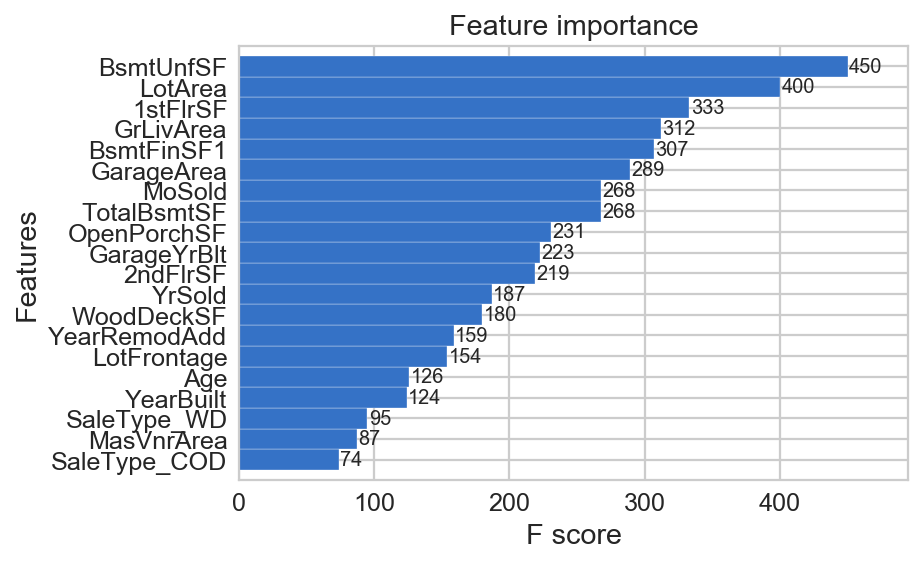

In [56]:
xgb_classif.fit(X_train, y_train)
xgb.plot_importance(xgb_classif, max_num_features=20, height = 1);

In [57]:
param = {
    'max_depth' : range(3, 10, 2),
    'min_child_weight' : range(1 , 6, 2)
}
gsearch = GridSearchCV(xgb_classif, param_grid = param,n_jobs=-1, iid=False, cv=10, verbose=10)

In [58]:
gsearch.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.7min


KeyboardInterrupt: 

In [ ]:
gsearch.cv_results_, gsearch.best_params_, gsearch.best_score_

In [ ]:
gsearch.score(X_test, y_test)

In [ ]:
# # Took 847.7min to complete the training
# #{'gamma': 0.3, 'max_depth': 11, 'min_child_weight': 1, 'reg_alpha': 0.005},
# # 0.9311691711682842
# param_2 = {
#     'max_depth' : [9, 10, 11],
#     'min_child_weight' : [1, 2],
#     'gamma':[i/10 for i in range(0,5)],
#     'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
# }
# gsearch_2 = GridSearchCV(xgb_classif, param_grid = param_2, n_jobs=-1, iid=False, cv=10, verbose=100, return_train_score=True)
# gsearch_2.fit(X_train, y_train)
# gsearch_2.cv_results_, gsearch_2.best_params_, gsearch_2.best_score_

In [ ]:
# joblib.dump(gsearch_2, 'XGBClf_imbalanced_model.sav')

In [ ]:
gsearch_2 = joblib.load('XGBClf_imbalanced_model.sav')

In [ ]:
gsearch_2.score(X_test, y_test)

In [ ]:
param_3 = {
    'max_depth' : [11, 12, 13],
    'min_child_weight' : [1],
    'gamma':[0.3],
    'reg_alpha':[0.005]
}
gsearch_3 = GridSearchCV(xgb_classif, param_grid = param_3, n_jobs=-1, iid=False, cv=10, verbose=10, return_train_score=True)
gsearch_3.fit(X_train, y_train)
gsearch_3.cv_results_, gsearch_3.best_params_, gsearch_3.best_score_

In [ ]:
xgb_classif.score(X_test, y_test)